# Github EDA
## Data Source:
GitHub [GraphQL](https://docs.github.com/en/graphql) and [REST](https://docs.github.com/en/rest?apiVersion=2022-11-28) APIs.

## Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_json('../data/gh.json', orient='index')
df.head()

,followers,forks,issues,login,pullRequests,sponsoring,sponsors,stars,totalContributions
2223165869,3,0,0,2223165869,0,0,0,0,0
JacobDavenport,0,0,0,JacobDavenport,0,0,0,0,0
tfevens,9,0,7,tfevens,27,0,0,0,9
Kmulla,0,1,0,Kmulla,0,0,0,1,0
mcbuddies,0,0,0,mcbuddies,0,0,0,1,0


In [3]:
## check column types
df.dtypes

followers              int64
forks                  int64
issues                 int64
login                 object
pullRequests           int64
sponsoring             int64
sponsors               int64
stars                  int64
totalContributions     int64
dtype: object

## General Stats

In [4]:
df.describe()

,followers,forks,issues,pullRequests,sponsoring,sponsors,stars,totalContributions
count,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000
mean,12.076468,15.453873,16.735076,23.655649,0.008880,0.004440,75.996547,113.214110
std,85.115870,177.201015,91.931851,219.175253,0.147101,0.142187,957.568090,1050.893029
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,1.000000,3.000000,2.000000,0.000000,0.000000,3.000000,1.000000
max,3070.000000,5556.000000,2041.000000,7498.000000,4.000000,6.000000,24101.000000,40799.000000


## Visualizations

### Histograms

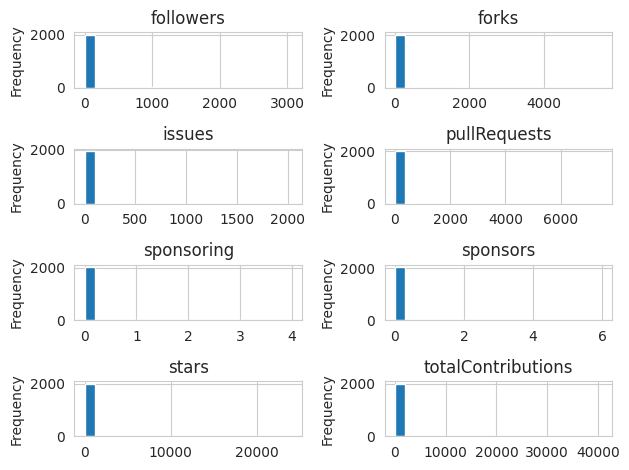

In [5]:
fig = plt.figure()
for i, stat in enumerate(df.select_dtypes('number').columns.tolist()):
    ax = fig.add_subplot(4, 2, i+1)
    df[stat].plot(kind='hist', ax=ax, bins=20)
    ax.set_title(stat)

fig.tight_layout()
plt.show();

### Boxplots

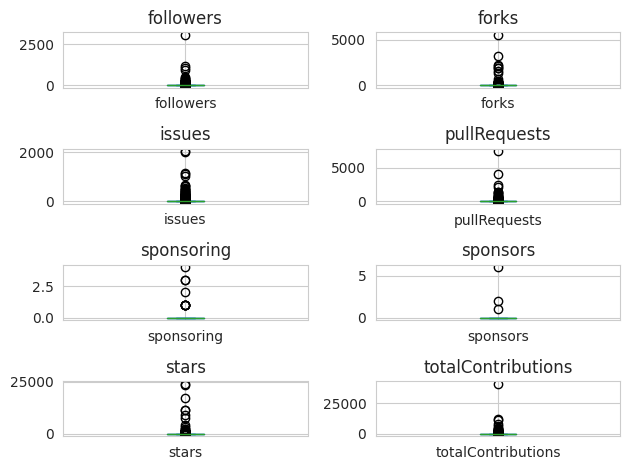

In [6]:
fig = plt.figure()
for i, stat in enumerate(df.select_dtypes('number').columns.tolist()):
    ax = fig.add_subplot(4, 2, i+1)
    df[stat].plot(kind='box', ax=ax)
    ax.set_title(stat)

fig.tight_layout()
plt.show();

Very skewed data. Let's visualize the log of the numerical data instead.

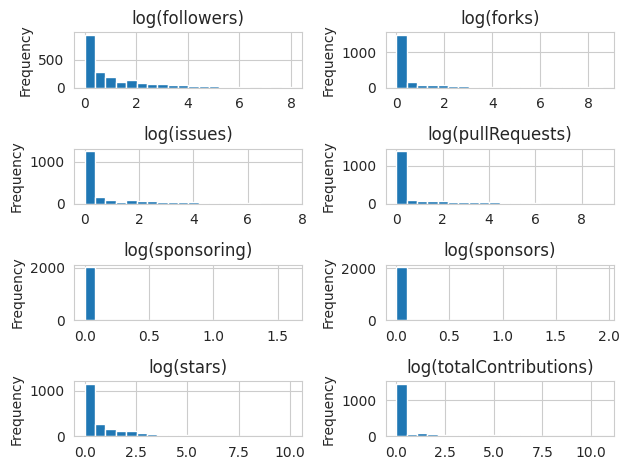

In [7]:
fig = plt.figure()
for i, stat in enumerate(df.select_dtypes('number').columns.tolist()):
    ax = fig.add_subplot(4, 2, i+1)
    df[stat].apply(lambda x: np.log(x+1)).plot(kind='hist', ax=ax, bins=20)
    ax.set_title('log('+stat+')')

fig.tight_layout()
plt.show();

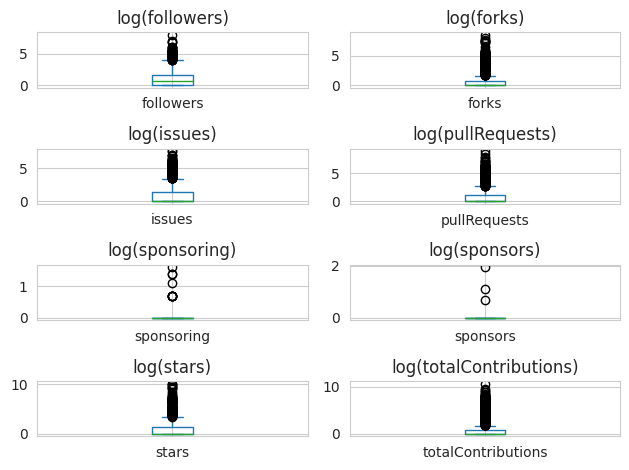

In [8]:
fig = plt.figure()
for i, stat in enumerate(df.select_dtypes('number').columns.tolist()):
    ax = fig.add_subplot(4, 2, i+1)
    df[stat].apply(lambda x: np.log(x+1)).plot(kind='box', ax=ax)
    ax.set_title('log('+stat+')')

fig.tight_layout()
plt.show();

Can we get a better idea of the distribution of the data by looking at the quantiles?

In [9]:
df.quantile([0.25, 0.5, 0.6, 0.75, 0.9, 0.95, 0.99, 0.999], interpolation='lower')

,followers,forks,issues,pullRequests,sponsoring,sponsors,stars,totalContributions
0.250,0,0,0,0,0,0,0,0
0.500,1,0,0,0,0,0,0,0
0.600,1,0,0,0,0,0,1,0
0.750,4,1,3,2,0,0,3,1
0.900,18,6,24,23,0,0,15,95
0.950,44,19,65,60,0,0,50,489
0.990,181,214,309,444,0,0,998,1751
0.999,931,2052,1116,2168,2,0,11442,7649


Can we reduce the number of features by ignoring those that are correlated?

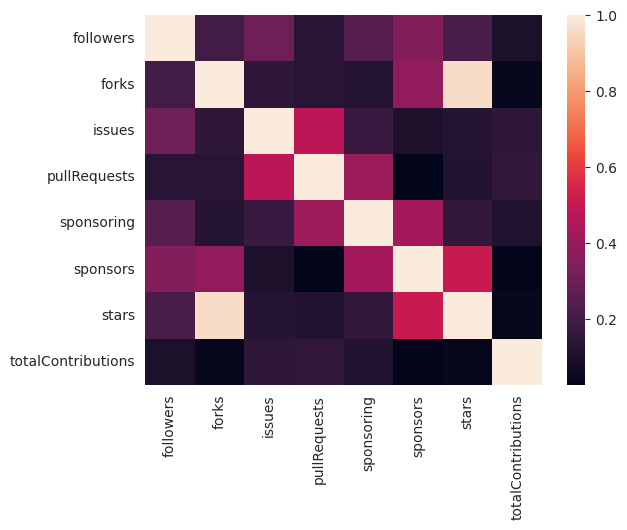

In [10]:
# plot a correlation heatmap
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns);

Forks and stars count are highly correlated, let's just use stars.

In [11]:
df.drop(columns=['forks'], inplace=True)

### Scatterplots

/home/r1oga/.pyenvs/ig-eda/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


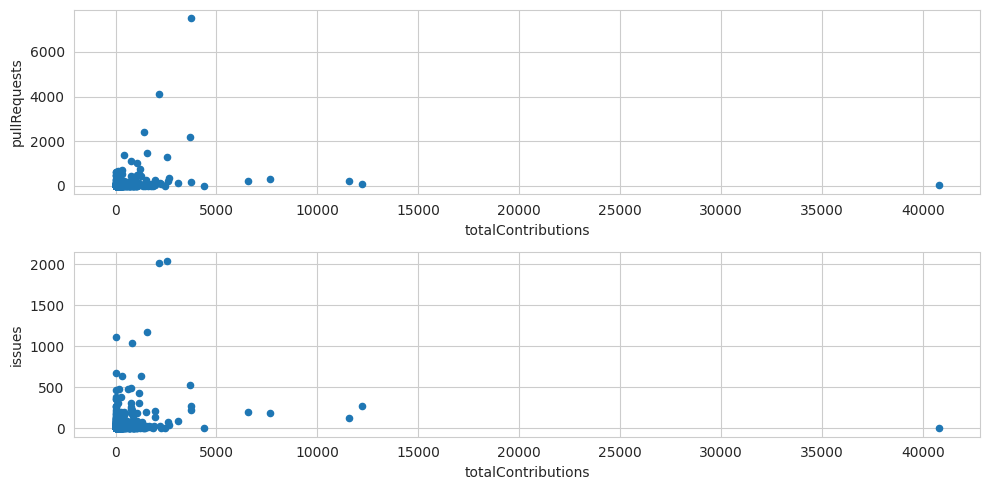

In [12]:
# plot 2 subplots in 1 column
# 1 scatterplot of totalContributions vs pullRequests
# 1 scatterplot of totalContributions vs issues
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
df.plot(kind='scatter', x='totalContributions', y='pullRequests', ax=axes[0])
df.plot(kind='scatter', x='totalContributions', y='issues', ax=axes[1])
fig.tight_layout()
plt.show();

Total contributions, pull requests and issues aren't correlated.
Let's keep only totalContributions still (includes comments, commits, issues, pull requests, reviews...).

In [13]:
# drop pullRequests and issues
df.drop(columns=['pullRequests', 'issues'], inplace=True)

## Bins

In [14]:
STARS_BINS = [(0, 1), (1, 10), (10, 50), (50, 1000), (1000, df['stars'].max() + 1)]
count, _ = np.histogram(df['stars'], bins=[b[0] for b in STARS_BINS] + [STARS_BINS[-1][1]])
count

array([1154,  594,  176,   82,   21])

In [15]:
FOLLOWERS_BINS = [(0, 2), (2, 20), (20, 100), (100, 500), (500, df['followers'].max() + 1)]
count, _ = np.histogram(df['followers'], bins=[b[0] for b in FOLLOWERS_BINS] + [FOLLOWERS_BINS[-1][1]])
count

array([1227,  607,  146,   43,    4])

In [16]:
TOTAL_CONTRIBUTIONS_BINS = [(0, 1), (1, 100), (100, 1000), (1000, 10000), (10000, df['totalContributions'].max() + 1)]
count, _ = np.histogram(df['totalContributions'], bins=[b[0] for b in TOTAL_CONTRIBUTIONS_BINS] + [TOTAL_CONTRIBUTIONS_BINS[-1][1]])
count

array([1460,  366,  149,   49,    3])

## Reputation Calculation Simulation

In [17]:
from tiers import TIERS

def points_per_metric(metric, metric_bins):
    for i, (lower, upper) in enumerate(metric_bins):
        if lower <= metric < upper:
            return i+1
    return 0

def points(stars, followers, totalContributions, sponsors, sponsoring):
    if sponsors + sponsoring > 0:
        return 4

    return points_per_metric(stars, STARS_BINS) + points_per_metric(followers, FOLLOWERS_BINS) + points_per_metric(totalContributions, TOTAL_CONTRIBUTIONS_BINS)

df['points'] = df.apply(lambda x: points(x['stars'], x['followers'], x['totalContributions'], x['sponsors'], x['sponsoring']), axis=1)

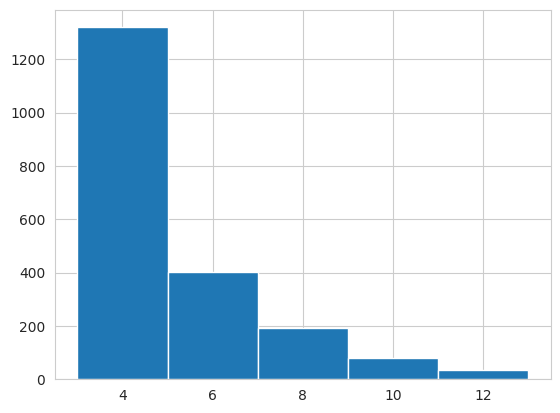

In [18]:
df['points'].hist(bins=5);

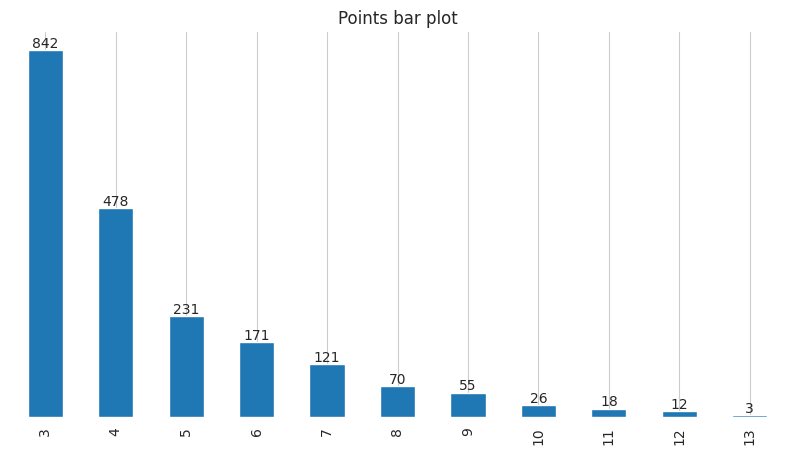

In [19]:
plt = df['points'].value_counts().plot.bar(title='Points bar plot', width=0.5, figsize=(10, 5))
plt.axes.get_yaxis().set_visible(False)
plt.bar_label(plt.containers[0])

# hide frame
plt.spines['top'].set_visible(False)
plt.spines['right'].set_visible(False)
plt.spines['bottom'].set_visible(False)
plt.spines['left'].set_visible(False)

In [20]:
POINT_BINS = [(0, 4), (4, 6), (6, 8), (8, 11), (11, df['points'].max() + 1)]
count, _ = np.histogram(df['points'], bins=[b[0] for b in POINT_BINS] + [POINT_BINS[-1][1]])
count

array([842, 709, 292, 151,  33])

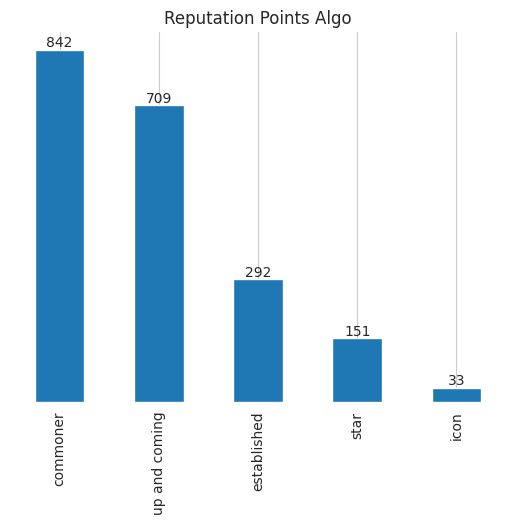

In [21]:
def reputation(points):
    for i, (lower, upper) in enumerate(POINT_BINS):
        if lower <= points < upper:
            return TIERS[i]["name"]

df['reputation'] = df['points'].apply(reputation)

plt = df['reputation'].value_counts().plot.bar(title='Reputation Points Algo')
plt.axes.get_yaxis().set_visible(False)
plt.bar_label(plt.containers[0])
plt.spines['top'].set_visible(False)
plt.spines['right'].set_visible(False)
plt.spines['bottom'].set_visible(False)
plt.spines['left'].set_visible(False)

### Stars + sponsor/sponsoring

In [22]:
df.head()

,followers,login,sponsoring,sponsors,stars,totalContributions,points,reputation
2223165869,3,2223165869,0,0,0,0,4,up and coming
JacobDavenport,0,JacobDavenport,0,0,0,0,3,commoner
tfevens,9,tfevens,0,0,0,9,5,up and coming
Kmulla,0,Kmulla,0,0,1,0,4,up and coming
mcbuddies,0,mcbuddies,0,0,1,0,4,up and coming


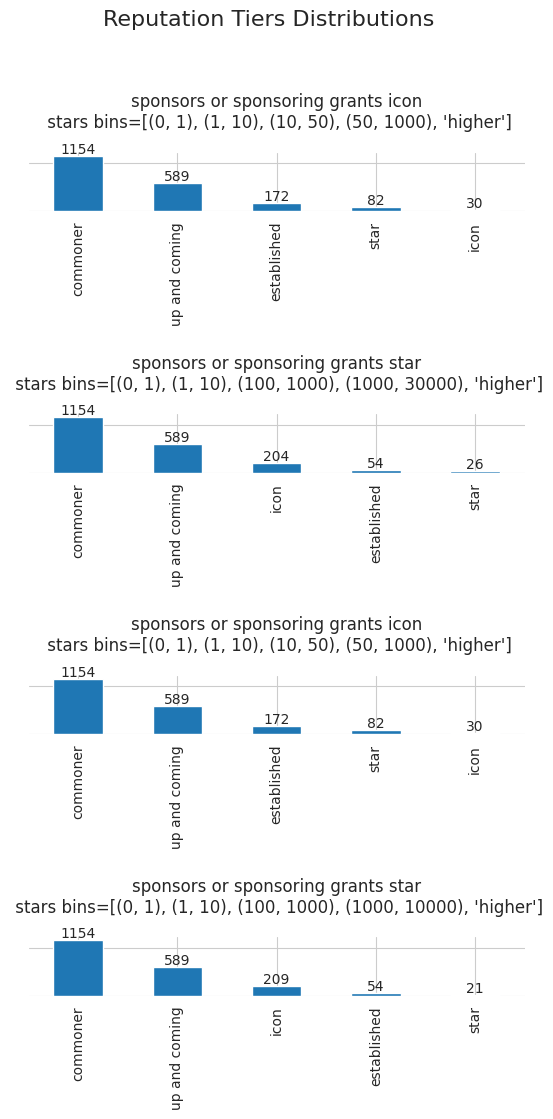

In [23]:
import matplotlib.pyplot as plt
from tiers import get_bin

BINS  = [
    [(0, 1), (1, 10), (10, 50), (50, 1000), (1000, df['stars'].max() + 1)],
    [(0, 1), (1, 10), (100, 1000), (1000, 30000), (30000, df['stars'].max() + 1)],
    [(0, 1), (1, 10), (10, 50), (50, 1000), (1000, df['stars'].max() + 1)],
    [(0, 1), (1, 10), (100, 1000), (1000, 10000), (10000, df['stars'].max() + 1)],
         ]
SPONSORS = [4,3,4,3]


def reputation_func(n):
    def rep_func(stars, sponsors, sponsoring):
        stars_bin = get_bin(stars, BINS[n])
        return TIERS[max(stars_bin, SPONSORS[n])] if (sponsors + sponsoring > 0) else TIERS[stars_bin]

    return rep_func

fig2 = plt.figure()
fig2.suptitle('Reputation Tiers Distributions', fontsize=16, y=3.6)

for i in range(len(BINS)):
    df[f'reputation{i}'] = df.apply(lambda x: reputation_func(i)(x['stars'], x['sponsors'], x['sponsoring'])['name'], axis=1)
    ax = fig2.add_subplot(5, 1, i + 1)
    ax.set_title(f'sponsors or sponsoring grants {TIERS[SPONSORS[i]]["name"]}\n stars bins={BINS[i][:-1] + ["higher"]}', y=1.3)
    ax.axes.get_yaxis().set_visible(False)
    ax.bar_label(df[f'reputation{i}'].value_counts().plot.bar(ax=ax).containers[0])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(left = False, right = False , labelleft = False, bottom = False)

plt.subplots_adjust(top=3.3, bottom=1, hspace=3.5)
plt.show()
# fig2.savefig('../plots/reddit/reputation_sims.png', bbox_inches='tight')

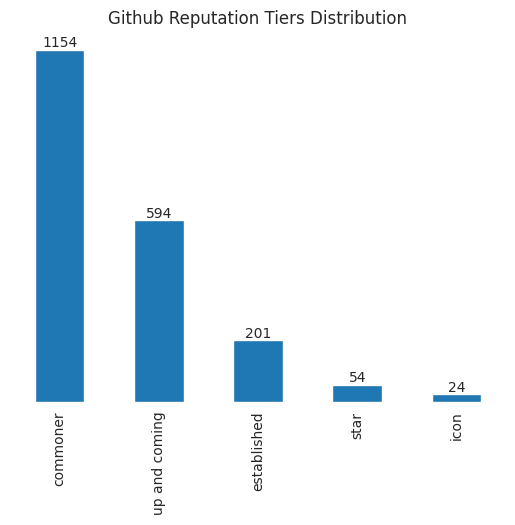

In [26]:
def reputation_final(stars, sponsors, sponsoring):
    if sponsors + sponsoring > 2:
        return TIERS[4]["name"]

    if stars < 1:
        return TIERS[0]["name"]
    elif stars < 10:
        return TIERS[1]["name"]
    elif stars < 100:
        return TIERS[2]["name"]
    elif stars < 1000:
        return TIERS[3]["name"]
    else:
        return TIERS[4]["name"]

df['reputation_final'] = df.apply(lambda x: reputation_final(x['stars'], x['sponsors'], x['sponsoring']), axis=1)

plt = df['reputation_final'].value_counts().plot.bar(title='Github Reputation Tiers Distribution')
plt.axes.get_yaxis().set_visible(False)
plt.bar_label(plt.containers[0])

# hide frame
plt.spines['top'].set_visible(False)
plt.spines['right'].set_visible(False)
plt.spines['bottom'].set_visible(False)
plt.spines['left'].set_visible(False)
plt.grid(False)

# save plot
plt.figure.savefig('../plots/github/reputation_final.png', bbox_inches='tight')

Rules

| stars  | 0   | 1-9   | 10-99       | 100-999 | 1000+ |
|--------|-----|-------|-------------|---------|-------|
| neither sponsored nor sponsoring | commoner | up-and-coming | established | star    | icon  |
| sponsors or sponsoring | established | established | established | star    | icon  |